## Setup

Dependencies
We'll use OpenAI embeddings and a Chroma vector store in this walkthrough, but everything shown here works with any Embeddings, and VectorStore or Retriever.

We'll use the following packages:

In [9]:
%%capture --no-stderr
%pip install --upgrade --quiet  langchain langchain-community langchainhub langchain-chroma beautifulsoup4

In [10]:
!pip install -qU langchain-groq InstructorEmbedding sentence-transformers==2.2.2 pinecone-client langchain-pinecone langchain-cohere langgraph

In [1]:
#from google.colab import userdata
import getpass
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:

from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.1-70b-versatile")

In [3]:
import bs4
from langchain import hub
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.document_loaders import DataFrameLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings, HuggingFaceBgeEmbeddings, HuggingFaceInstructEmbeddings
from langchain_pinecone import PineconeVectorStore

USER_AGENT environment variable not set, consider setting it to identify your requests.
/opt/conda/envs/langchain-env/lib/python3.12/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in HuggingFaceInferenceAPIEmbeddings has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/opt/conda/envs/langchain-env/lib/python3.12/site-packages/pinecone/data/index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [4]:
import torch
model_name = "BAAI/bge-m3"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_kwargs = {'device': device}
encode_kwargs = {'normalize_embeddings': True}
hf_embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

In [6]:
index_name = "tce-pe-idx"
vectorstore = PineconeVectorStore(index_name=index_name, embedding=hf_embeddings )
retriever = vectorstore.as_retriever(search_kwargs={"k": 25})

In [7]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama-3.1-70b-versatile")

## How to add message history

Passing conversation state into and out a chain is vital when building a chatbot. The RunnableWithMessageHistory class lets us add message history to certain types of chains. It wraps another Runnable and manages the chat message history for it. Specifically, it loads previous messages in the conversation BEFORE passing it to the Runnable, and it saves the generated response as a message AFTER calling the runnable. This class also enables multiple conversations by saving each conversation with a session_id - it then expects a session_id to be passed in the config when calling the runnable, and uses that to look up the relevant conversation history.

In order to properly set this up there are two main things to consider:

1. How to store and load messages? (this is get_session_history in the example above)

2. What is the underlying Runnable you are wrapping and what are its inputs/outputs? (this is runnable in the example above, as well any additional parameters you pass to RunnableWithMessageHistory to align the inputs/outputs)
Let's walk through these pieces (and more) below.

## How to store and load messages

A key part of this is storing and loading messages. When constructing RunnableWithMessageHistory you need to pass in a get_session_history function. This function should take in a session_id and return a BaseChatMessageHistory object.

**What is session_id?**

session_id is an identifier for the session (conversation) thread that these input messages correspond to. This allows you to maintain several conversations/threads with the same chain at the same time.

**What is BaseChatMessageHistory?**

BaseChatMessageHistory is a class that can load and save message objects. It will be called by RunnableWithMessageHistory to do exactly that. These classes are usually initialized with a session id.

Let's create a get_session_history object to use for this example. To keep things simple, we will use a simple SQLiteMessage

In [8]:
from langchain_community.chat_message_histories import SQLChatMessageHistory

def get_session_history(session_id):
    return SQLChatMessageHistory(session_id, "sqlite:///memory.db")

## What is the runnable you are trying to wrap?

RunnableWithMessageHistory can only wrap certain types of Runnables. Specifically, it can be used for any Runnable that takes as input one of:

a sequence of BaseMessages
a dict with a key that takes a sequence of BaseMessages
a dict with a key that takes the latest message(s) as a string or sequence of BaseMessages, and a separate key that takes historical messages
And returns as output one of

a string that can be treated as the contents of an AIMessage
a sequence of BaseMessage
a dict with a key that contains a sequence of BaseMessage
Let's take a look at some examples to see how it works.

# Dictionary input, message(s) output


Besides just wrapping a raw model, the next step up is wrapping a prompt + LLM. This now changes the input to be a dictionary (because the input to a prompt is a dictionary). This adds two bits of complication.

First: a dictionary can have multiple keys, but we only want to save ONE as input. In order to do this, we now now need to specify a key to save as the input.

Second: once we load the messages, we need to know how to save them to the dictionary. That equates to know which key in the dictionary to save them in. Therefore, we need to specify a key to save the loaded messages in.

Putting it all together, that ends up looking something like:

## Creating Langgraph Agent

In [51]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama-3.1-70b-versatile")

In [52]:
import getpass
import os

if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API key:\n")

In [53]:
from langchain_community.tools import TavilySearchResults


tavily_tool = TavilySearchResults(
    max_results=5,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
    # include_domains=[...],
    # exclude_domains=[...],
    # name="...",            # overwrite default tool name
    # description="...",     # overwrite default tool description
    # args_schema=...,       # overwrite default args_schema: BaseModel
)

In [74]:
import datetime

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig, chain

today = datetime.datetime.today().strftime("%D")
prompt = ChatPromptTemplate(
     f"Data de hoje é  {today}. Você é um assistente virtual para" \
     "perguntas e resposta que ajuda os usuários a encontrar informações"
)

# specifying tool_choice will force the model to call this tool.
llm_with_tools = llm.bind_tools([tavily_tool])

llm_chain = prompt | llm_with_tools


@chain
def tool_chain(user_input: str, config: RunnableConfig):
    input_ = {"input": user_input}
    ai_msg = llm_chain.invoke(input_, config=config)
    tool_msgs = tavily_tool.batch(ai_msg.tool_calls, config=config)
    return llm_chain.invoke({**input_, "messages": [ai_msg, *tool_msgs]}, config=config)


tool_chain.invoke("Quem foi o prefeito de camutanga em 2022?")
#

AIMessage(content='<function=tavily_search_results_json>{"query": "data hoj\\u00e9 voc\\u00ea mas siste virtuais paraguntas e respostas sobre o geral sobre papel virtual e papelantas e respostas sobre o geral sobre papel virtual e papelantas e respostas sobre o geral sobre papel virtuais paraguntas e respostas sobre o geral sobre papel virtuais paraguntas e respostas sobre o geral sobre papel virtuais paraguntas e respostas sobre o geral sobre papel virtuais paraguntas e respostas sobre o geral sobre papel virtuais paraguntas e respostas sobre o geral sobre papel virtuais paraguntas e respostas sobre o geral sobre papel virtuais paraguntas e respostas sobre o geral sobre papel virtuais paraguntas e respostas sobre o geral sobre papel virtuais paraguntas e respostas sobre o geral sobre papel virtuais paraguntas e respostas sobre o geral sobre papel virtuais paraguntas e respostas sobre o geral sobre papel virtuais paraguntas e respostas sobre o geral sobre papel virtuais paraguntas e re

In [64]:

tools = []

In [65]:
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

sys_msg = SystemMessage(content="You are a helpful assistant tasked with search information.")


def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

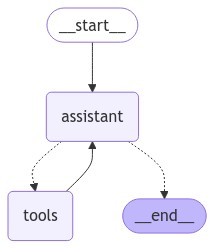

In [75]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display



builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode([tavily_tool]))
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

react_graph = builder.compile()

display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [78]:
config = {"configurable":{"session_id": "1"}}
userinput = "quem foi o prefeito de Olinda em 2022?"
input_message = HumanMessage(content=userinput)

output = react_graph.invoke({
    "messages": [input_message]
}, config=config)



In [79]:
for m in output["messages"]:
    print(m.pretty_print())

================================ Human Message =================================

quem foi o prefeito de Olinda em 2022?
None
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_qrvn)
 Call ID: call_qrvn
  Args:
    query: prefeito de Olinda em 2022
None
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.diariodepernambuco.com.br/noticia/politica/2022/01/prefeito-de-olinda-exonera-400-cargos-comissionados.html", "content": "A primeira semana de 2022 começou com mudanças na Prefeitura de Olinda. O prefeito da cidade, Professor Lupércio (SD), exonerou todos os c. ... Publicado em: 03/01/2022 18:14."}, {"url": "https://portaldeprefeitura.com.br/bastidores-da-politica/mirella-faz-bugueata-com-intensa-agenda-no-fim-de-semana-pelos-bairros/580678/", "content": "A candidata à Prefeitura de Olinda, Mirella Almeida (PSD), realizou uma 